In [1]:
sys.path.append('/Users/jacoblourie')

In [2]:
import tensorflow as tf
import sys
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
#From my own library
from computer_vision.my_lib.blur_contrast import display_image
import pandas as pd

## Trying to build a full 3 layer neural net from scratch using MNIST data

In [3]:
#Load the dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()


#need to make it smaller though
# x_train = x_train[0:10000]
# y_train = y_train[0:10000]

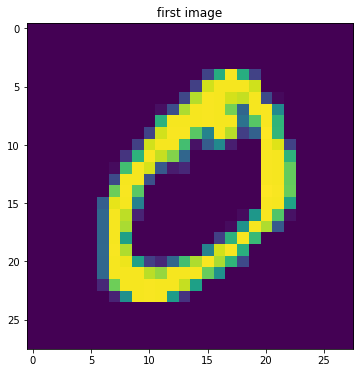

In [4]:
#see what an image looks like
display_image(x_train[1],'first image', size=(6,6))

## To make this simple, we will start by runnin a "is it a 1? " model 
We want to run a 1/0 model, so let's label all "1"s as 1, and everything else as 0

In [5]:
binary_y_train = np.array([1 if y == 1 else 0 for y in y_train])
binary_y_test = np.array([1 if y == 1 else 0 for y in y_test])

Let's go for 2 hidden layers, of 50 and 50 levels and let's just use sigmoid functions for now

In [6]:
#this helps much simpler
def flatten_and_reshape(x_train,x_test, y_train, y_test):

    x_train_flat = x_train.reshape((x_train.shape[0],-1)).T / 255
    x_test_flat = x_test.reshape((x_test.shape[0],-1)).T / 255
    print(x_train_flat.shape)
    bin_y_train = y_train.reshape(1,-1)
    bin_y_test = y_test.reshape(1,-1)
    return x_train_flat, x_test_flat, bin_y_train, bin_y_test

x_train_flat, x_test_flat, bin_y_train, bin_y_test = flatten_and_reshape(x_train, x_test, binary_y_train, binary_y_test)

#Create the binary model

# y_train_transp = y_train.reshape(1,-1) 
# y_test_transp = y_test.reshape(1,-1)



(784, 60000)


We'll go with a Gaussian initialisation of matrices

In [34]:
#Let's create the 'weights' matrices
def init_weights(x_train_flat, layer_1, layer_2,output):
    np.random_state = 112
    layer_1 = layer_1
    layer_2 = layer_2
    size_of_layer = [x_train_flat.shape[0], layer_1,layer_2, output]
    dict_of_weights = {}

    for layer in range(len(size_of_layer) - 1):
        dict_of_weights[f"W{layer+1}"] = np.random.randn(size_of_layer[layer+1],size_of_layer[layer])
        dict_of_weights[f"B{layer+1}"] = np.random.randn(size_of_layer[layer+1],1)
    #Print the sizes of the matrix
    print(f"Weights matrices")
    for name, matrix in dict_of_weights.items():
        print(name, matrix.shape)
    return dict_of_weights

dict_of_weights = init_weights(x_train_flat, 50, 15, 1)

Weights matrices
W1 (50, 784)
B1 (50, 1)
W2 (15, 50)
B2 (15, 1)
W3 (1, 15)
B3 (1, 1)


## To start with, let's do sigmoid activation for each layer

In [8]:
def sigmoid(x):
    return (1/(1+np.exp(-x)))

dict_of_FP_values = {}
#FORWARD PROPOGATION
def sigmoid_forward_prop(previous_a, W, B):
    Z = W @ previous_a + B
    next_A = sigmoid(Z)
    return Z, next_A

def forward_prop(dict_of_weights,x_train_flat,bin_y_train):
    W1, B1, W2, B2, W3, B3 = dict_of_weights.values()
    
    Z1, A1 = sigmoid_forward_prop(x_train_flat, W1, B1)
    Z2, A2 = sigmoid_forward_prop(A1, W2, B2)    
    Z3, A3 = sigmoid_forward_prop(A2, W3, B3)
    
    dict_of_FP_values['Z1'] = Z1
    dict_of_FP_values['A1'] = A1
    dict_of_FP_values['Z2'] = Z2
    dict_of_FP_values['A2'] = A2
    dict_of_FP_values['Z3'] = Z3
    dict_of_FP_values['A3'] = A3
    
    Cost = ((bin_y_train - A3) @ np.transpose(bin_y_train - A3) / A3.size )[0]

    return dict_of_FP_values, Cost

dict_of_FP_values, Cost = forward_prop(dict_of_weights,x_train_flat,bin_y_train)

## Great, so now we need to do back propogation.



Worth nothing, that everything is positive - this kind of makes sense because right now the dumb model can be improved by just setting everything to 0 (as only 10% of outputs are "1")

Let's keep going back through the differentials

In [9]:
differentiat_dict = {} #putting this here for later

In [10]:
def back_prop_one_layer_from_A_to_previous_A(cost_of_that_A, Z, prev_A,W):    
        #going back from A to z
        dAn_dZn = np.exp(-Z) / ((1+np.exp(-Z))**2)
        dC_dZn = cost_of_that_A * dAn_dZn
        
        #get diffs at that layer
        dZn_dWn = prev_A
        dZn_dBn = np.zeros_like(Z) + 1

        #combien to get useful differentials
        dC_dWn = dC_dZn @ dZn_dWn.T
        dC_dBn = np.sum(dC_dZn @ dZn_dBn.T,axis=1,keepdims=True)

        #and then get the previous layer cost fuctions
        dZn_dA_minus_one = W
        dC_dA_minus_one = (dC_dZn.T @ dZn_dA_minus_one).T

        return dC_dWn, dC_dBn, dC_dZn, dC_dA_minus_one

def back_prop(dict_of_weights, dict_of_FP_values, bin_y_train, x_train_flat):
    W1, B1, W2, B2, W3, W3 = dict_of_weights.values()
    Z1, A1, Z2, A2, Z3, A3 = dict_of_FP_values.values()
    
    differentiat_dict = {}
    
    '''Let's look at W3 and B3 first'''
    
    #This line is unique
    dC_dA3 = 2*(A3 - bin_y_train)/A3.size #gives 1 by m matrix

    #do the back props
    dC_dW3, dC_dB3, dC_dZ3, dC_dA2 = back_prop_one_layer_from_A_to_previous_A(dC_dA3, Z3, A2, W3)
    dC_dW2, dC_dB2, dC_dZ2, dC_dA1 = back_prop_one_layer_from_A_to_previous_A(dC_dA2, Z2, A1, W2)
    dC_dW1, dC_dB1, dC_dZ1, dC_dA0 = back_prop_one_layer_from_A_to_previous_A(dC_dA1, Z1, x_train_flat, W1)


#     #dC / dA2 ~ dC/DZ3 * dZ3 / dA2
#     dZ3_dA2 =  W3 # z = WA + b. 1 x 50
#     dC_dA2 = (dC_dZ3.T @ dZ3_dA2).T #50 rows, each column is back to being a training example, and there are W2.column_size rows. 

#     #then repeat the back_prop from before
#     dA2_dZ2 = np.exp(-Z2) / ((1+np.exp(-Z2))**2) #still gives 50 x m
#     dC_dZ2 = dC_dA2 * dA2_dZ2 #still a 50 x m

#     dZ2_dW2 = A1 # which is now 50 x m (A1 also 50 x m)
#     dZ2_dB2 = np.zeros_like((Z2)) + 1 #we need a 50 x 1 matrix

#             #SECOND USEFUL DIFFERENTIALS
#     dC_dW2 = dC_dZ2 @ dZ2_dW2.T  #W2 is 50x 50. dC_dZ2 is a 50 x m , by dz2_dw2 which is a 50xm, but tranpose
#     dC_dB2 = np.sum(dC_dZ2 @ dZ2_dB2.T,axis=1,keepdims=True)

#     '''#Then let's go back and get the next layer'''

#     dZ2_dA1 =  W2 # z = WA + b. 1 x 50
#     dC_dA1 = (dC_dZ2.T @ dZ2_dA1).T #50 rows, each column is back to being a training example, and there are W1.column_size rows.

#     #then repeat the back_prop from before
#     dA1_dZ1 = np.exp(-Z1) / ((1+np.exp(-Z1))**2) #still gives 50 x m
#     dC_dZ1 = dC_dA1 * dA1_dZ1 #still a 50 x m

#     dZ1_dW1 = x_train_flat # which is now 50 x m (A1 also 50 x m)
#     dZ1_dB1 = np.zeros_like((Z1)) + 1 #we need a 50 x 1 matrix

#             #THIRD USEFUL DIFFERENTIALS
#     dC_dW1 = dC_dZ1 @ dZ1_dW1.T  #W2 is 50x 50. dC_dZ2 is a 50 x m , by dz2_dw2 which is a 50xm, but tranpose
#     dC_dB1 = np.sum(dC_dZ1 @ dZ1_dB1.T,axis=1,keepdims=True)

    #add this to the dictionary for later use.
    differentiat_dict['dW1'] = dC_dW1
    differentiat_dict['dB1'] = dC_dB1
    differentiat_dict['dW2'] = dC_dW2
    differentiat_dict['dB2'] = dC_dB2
    differentiat_dict['dW3'] = dC_dW3
    differentiat_dict['dB3'] = dC_dB3

    return differentiat_dict

differentiat_dict = back_prop(dict_of_weights, dict_of_FP_values, bin_y_train, x_train_flat)

## Great stuff, now we need to update the weights.

In [11]:
def gradient_descent(learning_rate, dict_of_weights, differentiat_dict):
    
    #we have dictionaries for the weights and the differentials, which we should be able to use quite easily here. They are also in order so we can kind of cheat... but let's not 
    for key, value in dict_of_weights.items():
        dict_of_weights[key] += -learning_rate * differentiat_dict[f'd{key}']
    
    
learning_rate = 0.1  #no idea if this is a good learning rate
gradient_descent(learning_rate, dict_of_weights, differentiat_dict)

## SO, now let's run this in a loop and see what happens to Cost

In [12]:
#We start with forward propogation, storing the cost
learning_rate = 0.1 #set an arbitrary learning rate... we can iterate and try a few others soon
iterations = 200
cost = []

for iteration in range(iterations):
    
    dict_of_FP_values, Cost = forward_prop(dict_of_weights,x_train_flat,bin_y_train)
    cost.append(Cost[0]) #add cost to the list.
    #then, do back prop, storing the differentials
    differentiat_dict = back_prop(dict_of_weights, dict_of_FP_values, bin_y_train, x_train_flat)

    #then, do the gradient descent. Nothing stored, the weights just update and we re-use the new values in forward prop.
    gradient_descent(learning_rate, dict_of_weights, differentiat_dict)
    if iteration % 100 == 0:
        print(f'iteration: {iteration}\ncost: {Cost}')

iteration: 0
cost: [0.10218441]
iteration: 100
cost: [0.09989155]


/Users/jacoblourie/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

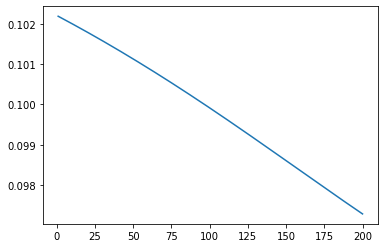

In [13]:
cost_x = np.linspace(1,iterations,iterations)
fig = plt.figure(figsize = (6,4))
sns.lineplot(cost_x,cost)


<AxesSubplot:ylabel='Count'>

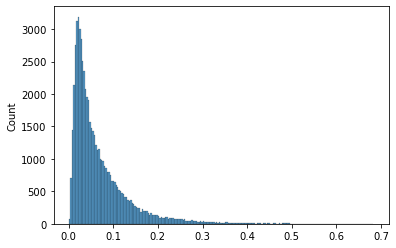

In [14]:
sns.histplot(dict_of_FP_values['A3'][0])

In [15]:
pd.Series(bin_y_train[0]).value_counts()

0    53258
1     6742
dtype: int64

In [16]:
pd.cut(pd.Series(dict_of_FP_values['A3'][0]), bins=10, right=False).value_counts()

[0.000774, 0.0689)    39299
[0.0689, 0.137)       13712
[0.137, 0.205)         4238
[0.205, 0.273)         1608
[0.273, 0.342)          640
[0.342, 0.41)           299
[0.41, 0.478)           117
[0.478, 0.546)           66
[0.546, 0.614)           14
[0.614, 0.683)            7
dtype: int64

## OK. It just seems to have optimised by making everything 0. Let's see what happens if we just have two numbers in the sample

In [17]:
#Get the indexes for 0s and 1s
y_train_list_form = np.array([1 if y == 1 else 0 if y == 0 else 5 for y in y_train])
y_train_1_2 = pd.DataFrame( {'value': y_train_list_form})
index_1 = (y_train_1_2['value'] == 1) | (y_train_1_2['value'] == 0 )

#Repeat this for test
y_test_list_form = np.array([1 if y == 1 else 0 if y == 0 else 5 for y in y_test])
y_test_1_2 = pd.DataFrame( {'value': y_test_list_form})
index_2 = (y_test_1_2['value'] == 1) | (y_test_1_2['value'] == 0 )

In [18]:
#then get the relevant lists
y_train_two_classes = y_train_list_form[index_1]
x_train_two_classes = x_train[index_1]
y_test_two_classes = y_test_list_form[index_2]
x_test_two_classes = x_test[index_2]

In [19]:
#flatten the shapes - note, we're not using x_test just yet, so can leave this as is.
x_train_2, x_test_2, y_train_2, y_test_2 = flatten_and_reshape(x_train_two_classes, x_test_two_classes, y_train_two_classes, y_test_two_classes)

(784, 12665)


In [20]:
#shows the split of class values
pd.Series(y_train_2[0]).value_counts()

1    6742
0    5923
dtype: int64

In [28]:

#init the weights
dict_of_weights_2 = init_weights(x_train_2, 50, 50, 1)

#then let's do some iterations
learning_rate = 0.12 #set an arbitrary learning rate... we can iterate and try a few others soon
iterations = 500
cost = []

for iteration in range(iterations):
    
    dict_of_FP_values_bin, Cost = forward_prop(dict_of_weights_2,x_train_2,y_train_2)
    cost.append(Cost[0]) #add cost to the list.
    #then, do back prop, storing the differentials
    differentiat_dict = back_prop(dict_of_weights_2, dict_of_FP_values_bin, y_train_2, x_train_2)

    #then, do the gradient descent. Nothing stored, the weights just update and we re-use the new values in forward prop.
    gradient_descent(learning_rate, dict_of_weights_2, differentiat_dict)



Weights matrices
W1 (50, 784)
B1 (50, 1)
W2 (50, 50)
B2 (50, 1)
W3 (1, 50)
B3 (1, 1)


In [29]:
y_train_2

array([[0, 1, 1, ..., 1, 0, 1]])

In [30]:
pd.cut(pd.Series(dict_of_FP_values_bin['A3'][0]), bins=10, right=False).value_counts()

[0.899, 1.0)         4426
[0.000815, 0.101)    3994
[0.799, 0.899)       1325
[0.101, 0.2)         1008
[0.699, 0.799)        561
[0.2, 0.3)            401
[0.599, 0.699)        320
[0.3, 0.4)            230
[0.5, 0.599)          205
[0.4, 0.5)            195
dtype: int64

Great - we have values at both ends of the spectrum!

/Users/jacoblourie/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

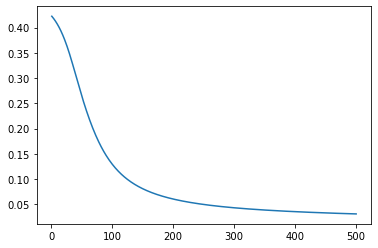

In [31]:
cost_x = np.linspace(1,iterations,iterations)
fig = plt.figure(figsize = (6,4))
sns.lineplot(cost_x,cost)

0.01 - what does this mean? it's the average of the sum of squared values. so on average the sum of the squared values is 0.01, which means the average modulus of the value is 0.1

## Next - let's use this to "Predict the Test Set"

In [32]:
def predict(vector_of_x, vector_of_y):
    FP_values, Cost = forward_prop(dict_of_weights_2,vector_of_x, vector_of_y)
    y_prob = FP_values['A3']
    #y_pred = round(FP_values['A3'])
    accuracy_vector = abs(y_prob - vector_of_y) < 0.5
    return y_prob,  accuracy_vector

prob, av = predict(x_test_2, y_test_2)

In [33]:
pd.Series(av[0]).value_counts()

True     2069
False      46
dtype: int64

## Alright, Let's move on to SoftMax function and try to predict correctly from all the numbers

We should also test the log versus non-logged form of the cost function, as the literature really supports the idea we should be using the logged form

In [35]:
#OK, let's get the data as we need it. we can use x_train_flat and x_test_flat
print(x_train_flat.shape)
#for y, we need to do some form of hot encoding.
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder(sparse = False)
one_hot_y_train= one_hot.fit_transform(y_train.reshape(-1,1)).T
one_hot_y_test = one_hot.fit_transform(y_test.reshape(-1,1)).T


(784, 60000)


In [56]:
# let's see if we can initialise the weights
dict_of_weights_softmax = init_weights(x_train_flat, 50, 50, 10)

Weights matrices
W1 (50, 784)
B1 (50, 1)
W2 (50, 50)
B2 (50, 1)
W3 (10, 50)
B3 (10, 1)


## Gravy. Now let's take a look at the forward prop

One thing for sure is that we need to change the calculation of the cost function.

In [81]:
one_hot_y_train.shape

(10, 60000)

In [91]:
dict_of_FP_values_softmax = {}
#FORWARD PROPOGATION
def last_leg_softmax(previous_a, W, B):
    Z = W @ previous_a + B
    A = np.exp(Z)
    A = A / np.sum(A,axis=0) 
    return Z, A

def forward_prop_softmax(dict_of_weights,x_train_flat,y_train_softmax):
    W1, B1, W2, B2, W3, B3 = dict_of_weights.values()
    
    Z1, A1 = sigmoid_forward_prop(x_train_flat, W1, B1)
    Z2, A2 = sigmoid_forward_prop(A1, W2, B2)    
    Z3, A3 = last_leg_softmax(A2, W3, B3)
    
    dict_of_FP_values['Z1'] = Z1
    dict_of_FP_values['A1'] = A1
    dict_of_FP_values['Z2'] = Z2
    dict_of_FP_values['A2'] = A2
    dict_of_FP_values['Z3'] = Z3
    dict_of_FP_values['A3'] = A3
    
    #for cost fucntion, use the y log y_hat
    Cost = -np.sum(y_train_softmax * np.log(A3)) / y_train_softmax.shape[1]
    #Cost = ((y_train_softmax - A3) @ np.transpose(y_train_softmax - A3) / A3.size )[0]

    return dict_of_FP_values, Cost

dict_of_FP_values_softmax, Cost_softmax = forward_prop_softmax(dict_of_weights_SM,x_train_flat,one_hot_y_train)

In [92]:
def back_prop_first_soft_max_layer(y_true, y_predicted, previous_A, Z, W):    
        #dC/dz first layer is just y - ÿ
        dC_dZ_final = y_predicted - y_true
        
        #get diffs at that layer
        dZfinal_dW = previous_A
        dZfinal_dB = np.zeros_like(Z) + 1

        #combine to get useful differentials
        dC_dW = dC_dZ_final @ dZfinal_dW.T
        dC_dB = np.sum(dC_dZ_final @ dZfinal_dB.T,axis=1,keepdims=True)

        #and then get the previous layer cost fuctions
        dZfinal_dA_minus_one = W
        dC_dA_minus_one = (dC_dZ_final.T @ dZfinal_dA_minus_one).T

        return dC_dW, dC_dB, dC_dZ_final, dC_dA_minus_one

def back_prop(dict_of_weights_softmax, dict_of_FP_values_softmax, y_true, x_train_flat):
    W1, B1, W2, B2, W3, W3 = dict_of_weights_softmax.values()
    Z1, A1, Z2, A2, Z3, A3 = dict_of_FP_values_softmax.values()
    
    differentiat_dict = {}
    
    '''Let's look at W3 and B3 first'''
    
    #This line is unique
    dC_dW3, dC_dB3, dC_dZ_last, dC_dA2 = back_prop_first_soft_max_layer(y_true, A3, A2, Z3, W3)

    #do the back props
    #dC_dW3, dC_dB3, dC_dZ3, dC_dA2 = back_prop_one_layer_from_A_to_previous_A(dC_dA3, Z3, A2, W3)
    dC_dW2, dC_dB2, dC_dZ2, dC_dA1 = back_prop_one_layer_from_A_to_previous_A(dC_dA2, Z2, A1, W2)
    dC_dW1, dC_dB1, dC_dZ1, dC_dA0 = back_prop_one_layer_from_A_to_previous_A(dC_dA1, Z1, x_train_flat, W1)


    differentiat_dict['dW1'] = dC_dW1
    differentiat_dict['dB1'] = dC_dB1
    differentiat_dict['dW2'] = dC_dW2
    differentiat_dict['dB2'] = dC_dB2
    differentiat_dict['dW3'] = dC_dW3
    differentiat_dict['dB3'] = dC_dB3

    return differentiat_dict

differentiat_dict_softmax = back_prop(dict_of_weights_softmax, dict_of_FP_values_softmax, one_hot_y_train, x_train_flat)